## 1 numpy & gvar & lsqfit

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import gvar as gv
from lsqfit import nonlinear_fit

### 1.1

1. Calculate $y=e^{-t}$ for $t=0.0,0.2,0.4,\dots,2.0$
2. Add Gaussian noise $0.02\xi$ with $\xi\sim\mathcal{N}(0,1)$ to each $\{t_i,y_i\}$
3. Repeat Step 2 for 50 times, then you get 50 "samples"
4. Export your "samples" to `.npy` file

In [2]:
sample = np.zeros((50, 11))
t = np.linspace(0, 2, 11)
y = np.exp(-t)
for i in range(50):
    noise = 0.02 * np.random.normal(0, 1, (11))
    sample[i] = y + noise
np.save("sample.npy", sample)

### 1.2

1. Import previous generated `.npy` file
2. Calculate the mean value and standard deviation of each $y_i$
3. Plot $\{t_i,y_i\}$ with error bars in linear-log plot
4. Fit the data using model $f(x,\{c_1,c_2\})=c_1e^{-c_2t}$
5. Plot the best fit and data together in one figure

Least Squares Fit:
  chi2/dof [dof] = 0.03 [11]    Q = 1    logGBF = 25.142

Parameters:
             c1   1.003 (15)     [  1.0 (1.0) ]  
             c2   1.001 (25)     [  1.0 (1.0) ]  

Fit:
     x[k]          y[k]      f(x[k],p)
--------------------------------------
        0    1.005 (20)     1.003 (15)  
      0.2    0.819 (20)     0.821 (10)  
      0.4    0.678 (21)    0.6722 (75)  
      0.6    0.544 (16)    0.5502 (67)  
      0.8    0.452 (19)    0.4504 (67)  
        1    0.366 (19)    0.3686 (69)  
      1.2    0.303 (17)    0.3018 (69)  
      1.4    0.249 (18)    0.2470 (68)  
      1.6    0.205 (22)    0.2022 (65)  
      1.8    0.165 (19)    0.1655 (61)  
        2    0.136 (21)    0.1355 (57)  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 4/0.3s)
  fitter = scipy_least_squares    method = trf



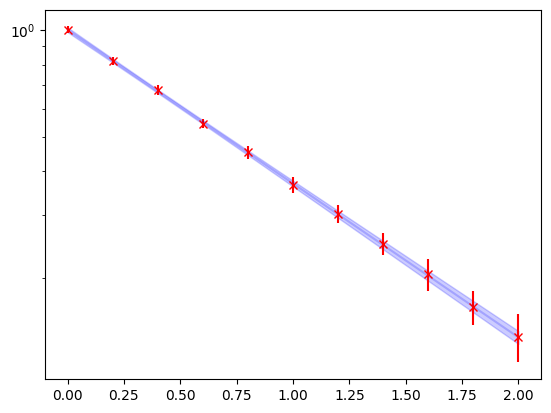

<Figure size 640x480 with 0 Axes>

In [3]:
def model(t, p):
    return p["c1"] * gv.exp(-p["c2"] * t)


data = np.load("sample.npy")
data_gv = gv.gvar(data.mean(0), data.std(0))
fit = nonlinear_fit((t, data_gv), model, {"c1": gv.gvar(1, 1), "c2": gv.gvar(1, 1)})
print(fit.format(True))
data_fit = model(t, fit.p)

plt.errorbar(t, gv.mean(data_gv), gv.sdev(data_gv), fmt="xr")
plt.plot(t, gv.mean(data_fit), ",-b", alpha=0.2)
plt.fill_between(t, gv.mean(data_fit) - gv.sdev(data_fit), gv.mean(data_fit) + gv.sdev(data_fit), color="b", alpha=0.2)
plt.yscale("log")
plt.show()
plt.clf()

## 2 强子两点关联函数

In [4]:
import numpy as np
from opt_einsum import contract

In [5]:
import cupy as cp

In [6]:
gamma_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
gamma_1 = np.array([[0, 0, 0, 1j], [0, 0, 1j, 0], [0, -1j, 0, 0], [-1j, 0, 0, 0]])
gamma_2 = np.array([[0, 0, 0, -1], [0, 0, 1, 0], [0, 1, 0, 0], [-1, 0, 0, 0]])
gamma_3 = np.array([[0, 0, 1j, 0], [0, 0, 0, -1j], [-1j, 0, 0, 0], [0, 1j, 0, 0]])
gamma_4 = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0]])
gamma_5 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, -1, 0], [0, 0, 0, -1]])
C = gamma_2 @ gamma_4
P = (gamma_0 + gamma_4) / 2
epsilon = np.zeros((3, 3, 3), np.int32)
for a in range(3):
    b, c = (a + 1) % 3, (a + 2) % 3
    epsilon[a, b, c] = 1
    epsilon[a, c, b] = -1

In [7]:
gamma_1 @ gamma_2 @ gamma_3 @ gamma_4

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]])

In [8]:
cfg = 10000
pion_numpy = np.zeros((4, 72), np.complex128)
proton_numpy = np.zeros((4, 72), np.complex128)

In [9]:
pion_cupy = cp.zeros((4, 72), cp.complex128)
proton_cupy = cp.zeros((4, 72), cp.complex128)

### 2.1 $\pi$ 介子两点关联函数

我们有
$$
S_{t_0}(t,z,y,x,\beta,\beta',a,a')=G^{u/d}(t,z,y,x,\beta,a;t_0,z_0,y_0,x_0,\beta',a')
$$

需要计算
$$
C(t)=\frac{1}{N_{t_0}}\sum_{t_0}C_{t_0}(t_0+t)=\frac{1}{N_{t_0}}\sum_{t_0}\left\lang\mathcal{O}(t_0+t)\mathcal{O}^\dagger(t_0)\right\rang\\
C_{t_0}(t)=\left\lang\mathcal{O}(t)\mathcal{O}^\dagger(t_0)\right\rang=\sum_{z,y,x,a,a',\alpha,\alpha',\beta,\beta'}G^u(t,z,y,x,\beta,a;t_0,z_0,y_0,x_0,\beta',a')\left(\gamma_5\right)_{\beta'\alpha'}G^d(t_0,z_0,y_0,x_0,\alpha',a';t,z,y,x,\alpha,a)\left(\gamma_5\right)_{\alpha\beta}
$$

#### 2.1.1 $C_{t_0}(t)$

根据 $\gamma_5$-Hermiticity，可以得到
$$
\begin{aligned}
G(t_0,z_0,y_0,x_0,\alpha',a';t,z,y,x,\alpha,a)=&\left(\gamma_5\right)_{\alpha'\sigma'}G^\dagger(t_0,z_0,y_0,x_0,\sigma',a';t,z,y,x,\sigma,a)\left(\gamma_5\right)_{\sigma\alpha}\\
=&\left(\gamma_5\right)_{\alpha'\sigma'}G^*(t,z,y,x,\sigma,a;t_0,z_0,y_0,x_0,\sigma',a')\left(\gamma_5\right)_{\sigma\alpha}\\
=&\left(\gamma_5\right)_{\alpha'\sigma'}S_{t_0}^*(t,z,y,x,\sigma,\sigma',a,a')\left(\gamma_5\right)_{\sigma\alpha}
\end{aligned}
$$

$$
\begin{aligned}
C_{t_0}(t)=\left\lang\mathcal{O}(t)\mathcal{O}^\dagger(t_0)\right\rang=&\sum_{z,y,x,a,a',\alpha,\alpha',\beta,\beta'}G^u(t,z,y,x,\beta,a;t_0,z_0,y_0,x_0,\beta',a')\left(\gamma_5\right)_{\beta'\alpha'}G^d(t_0,z_0,y_0,x_0,\alpha',a';t,z,y,x,\alpha,a)\left(\gamma_5\right)_{\alpha\beta}\\
=&\sum_{z,y,x,a,a',\alpha,\alpha',\beta,\beta',\sigma,\sigma'}S_{t_0}(t,z,t,x,\beta,\beta',a,a')\left(\gamma_5\right)_{\beta'\alpha'}\left(\gamma_5\right)_{\alpha'\sigma'}S_{t_0}^*(t,z,y,x,\sigma,\sigma',a,a')\left(\gamma_5\right)_{\sigma\alpha}\left(\gamma_5\right)_{\alpha\beta}\\
=&\sum_{z,y,x,a,a',\beta,\beta',\sigma,\sigma'}S_{t_0}(t,z,t,x,\beta,\beta',a,a')\left(\gamma_5\gamma_5\right)_{\beta'\sigma'}S_{t_0}^*(t,z,y,x,\sigma,\sigma',a,a')\left(\gamma_5\gamma_5\right)_{\sigma\beta}\\
=&\sum_{z,y,x,a,b,i,j,k,l}S_{t_0}(t,z,y,x,i,j,a,b)\left(\gamma_5\gamma_5\right)_{jk}S_{t_0}^*(t,z,y,x,l,k,a,b)\left(\gamma_5\gamma_5\right)_{li}
\end{aligned}
$$

In [10]:
for tidx, tsrc in enumerate(range(0, 72, 72)):
    propag_numpy = np.load(f"./beta6.20_mu-0.2770_ms-0.2400_L24x72_cfg_{cfg}_hyp0_gfixed3.light.tsrc_{tsrc:02d}.npy")
    pion_numpy[tidx] = contract(
        "tzyxijab,jk,tzyxlkab,li->t",
        propag_numpy,
        gamma_5 @ gamma_5,
        propag_numpy.conj(),
        gamma_5 @ gamma_5,
    )

FileNotFoundError: [Errno 2] No such file or directory: './beta6.20_mu-0.2770_ms-0.2400_L24x72_cfg_10000_hyp0_gfixed3.light.tsrc_00.npy'

In [ ]:
for tidx, tsrc in enumerate(range(0, 72, 72)):
    propag_cupy = cp.load(f"./beta6.20_mu-0.2770_ms-0.2400_L24x72_cfg_{cfg}_hyp0_gfixed3.light.tsrc_{tsrc:02d}.npy")
    pion_cupy[tidx] = contract(
        "tzyxijab,jk,tzyxlkab,li->t",
        propag_cupy,
        cp.array(gamma_5 @ gamma_5),
        propag_cupy.conj(),
        cp.array(gamma_5 @ gamma_5),
    )

#### 2.1.2 $C(t)$

$$
C(t)=\frac{1}{N_{t_0}}\sum_{t_0}C_{t_0}(t_0+t)=\frac{1}{N_{t_0}}\sum_{t_0}C'_{t_0}(t)
$$

$$
C'_{t_0}(t)=C_{t_0}(t_0+t)
$$

`numpy.roll` 或 `cupy.roll` 可以将数据沿着某个轴进行平移，并进行周期性的扩展。

In [ ]:
print(np.arange(12))
print(np.roll(np.arange(12), -1, 0))
print(np.roll(np.arange(12), -4, 0))

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 1  2  3  4  5  6  7  8  9 10 11  0]
[ 4  5  6  7  8  9 10 11  0  1  2  3]


In [ ]:
for tidx, tsrc in enumerate(range(0, 72, 18)):
    pion_numpy[tidx] = np.roll(pion_numpy[tidx], -tsrc, 0)
pion_numpy_tsrc_mean = pion_numpy.mean(0)

In [ ]:
for tidx, tsrc in enumerate(range(0, 72, 18)):
    pion_cupy[tidx] = cp.roll(pion_cupy[tidx], -tsrc, 0)
pion_cupy_tsrc_mean = pion_cupy.mean(0)

In [ ]:
pion_numpy[0]

array([379116.43736879+0.j, 286375.73683229+0.j, 228801.42281157+0.j,
       184919.01309735+0.j, 152465.37024386+0.j, 134413.50789895+0.j,
       118356.19636203+0.j,  97286.86604439+0.j,  76100.68345687+0.j,
        59145.16206988+0.j,  46103.61021343+0.j,  37906.1328164 +0.j,
        32229.44611697+0.j,  27475.26812304+0.j,  22694.08554711+0.j,
        17927.17556702+0.j,  14262.82931735+0.j,  11772.58189565+0.j,
         9570.3241615 +0.j,   8038.18061352+0.j,   7157.95664776+0.j,
         6594.95396009+0.j,   5621.4525571 +0.j,   4687.52760241+0.j,
         3887.14139598+0.j,   3350.89539218+0.j,   2904.02345524+0.j,
         2627.12902435+0.j,   2442.54423056+0.j,   2296.29660764+0.j,
         2149.2386838 +0.j,   2125.79121242+0.j,   2091.36431231+0.j,
         1894.11479544+0.j,   1641.0779919 +0.j,   1472.19319008+0.j,
         1351.00134696+0.j,   1276.39055597+0.j,   1281.33492513+0.j,
         1390.74428753+0.j,   1528.92440687+0.j,   1611.303664  +0.j,
         1714.018476

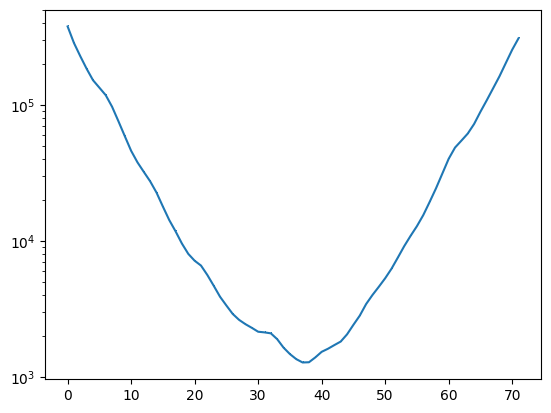

In [ ]:
plt.semilogy(np.arange(72), pion_cupy[0].get().real, ",-")

### 2.2 $N$ 质子两点关联函数

$$
C=i\gamma_2\gamma_4,\;P^+=\frac{1}{2}\left(\mathbb{I}+\gamma_4\right)
$$


#### 2.2.1 $C_{t_0}(t)$

需要计算
$$
\begin{aligned}
C_{t_0}(t)=&\sum_{z,y,x,a,a',b,b',c,c',\alpha,\alpha',\beta,\beta',\sigma,\sigma'}\left(C\gamma_5\right)_{\alpha\beta}\left(C\gamma_5\right)_{\alpha'\beta'}\epsilon_{abc}\epsilon_{a'b'c'}\left(P^+\right)_{\sigma\sigma'}\\
&G^u(t,z,y,x,\alpha,a;t_0,z_0,y_0,x_0,\alpha',a')G^d(t,z,y,x,\beta,b;t_0,z_0,y_0,x_0,\beta',b')G^u(t,z,y,x,\sigma,c;t_0,z_0,y_0,x_0,\sigma',c')\\
&-\sum_{z,y,x,a,a',b,b',c,c',\alpha,\alpha',\beta,\beta',\sigma,\sigma'}\left(C\gamma_5\right)_{\alpha\beta}\left(C\gamma_5\right)_{\alpha'\beta'}\epsilon_{abc}\epsilon_{a'b'c'}\left(P^+\right)_{\sigma\sigma'}\\
&G^u(t,z,y,x,\alpha,a;t_0,z_0,y_0,x_0,\sigma',c')G^d(t,z,y,x,\beta,b;t_0,z_0,y_0,x_0,\beta',b')G^u(t,z,y,x,\sigma,c;t_0,z_0,y_0,x_0,\alpha',a')\\
=&\sum_{z,y,x,a,a',b,b',c,c',\alpha,\alpha',\beta,\beta',\sigma,\sigma'}\left(C\gamma_5\right)_{\alpha\beta}\left(C\gamma_5\right)_{\alpha'\beta'}\epsilon_{abc}\epsilon_{a'b'c'}\left(P^+\right)_{\sigma\sigma'}S(t,z,y,x,\alpha,\alpha',a,a')S(t,z,y,x,\beta,\beta',b,b')S(t,z,y,x,\sigma,\sigma',c,c')\\
&-\sum_{z,y,x,a,a',b,b',c,c',\alpha,\alpha',\beta,\beta',\sigma,\sigma'}\left(C\gamma_5\right)_{\alpha\beta}\left(C\gamma_5\right)_{\alpha'\beta'}\epsilon_{abc}\epsilon_{a'b'c'}\left(P^+\right)_{\sigma\sigma'}S(t,z,y,x,\alpha,\sigma',a,c')S(t,z,y,x,\beta,\beta',b,b')S(t,z,y,x,\sigma,\alpha',c,a')\\
=&\sum_{z,y,x,a,b,c,d,e,f,i,j,k,l,m,n}\left(C\gamma_5\right)_{ij}\left(C\gamma_5\right)_{kl}\epsilon_{abc}\epsilon_{def}\left(P^+\right)_{mn}S(t,z,y,x,i,k,a,d)S(t,z,y,x,j,l,b,e)S(t,z,y,x,m,n,c,f)\\
&-\sum_{z,y,x,a,b,c,d,e,f,i,j,k,l,m,n}\left(C\gamma_5\right)_{ij}\left(C\gamma_5\right)_{kl}\epsilon_{abc}\epsilon_{def}\left(P^+\right)_{\sigma\sigma'}S(t,z,y,x,i,n,a,f)S(t,z,y,x,j,l,b,e)S(t,z,y,x,m,k,c,d)\\
\end{aligned}
$$

In [ ]:
for tidx, tsrc in enumerate(range(0, 72, 72)):
    propag_numpy = np.load(f"./beta6.20_mu-0.2770_ms-0.2400_L24x72_cfg_{cfg}_hyp0_gfixed3.light.tsrc_{tsrc:02d}.npy")
    proton_numpy[tidx] = contract(
        "ij,kl,abc,def,mn,tzyxikad,tzyxjlbe,tzyxmncf->t",
        C @ gamma_5,
        C @ gamma_5,
        epsilon,
        epsilon,
        P,
        propag_numpy,
        propag_numpy,
        propag_numpy,
    )
    proton_numpy[tidx] -= contract(
        "ij,kl,abc,def,mn,tzyxinaf,tzyxjlbe,tzyxmkcd->t",
        C @ gamma_5,
        C @ gamma_5,
        epsilon,
        epsilon,
        P,
        propag_numpy,
        propag_numpy,
        propag_numpy,
    )

In [ ]:
# proton_numpy[tidx] = contract(
#     "ij,kl,abc,def,mn,tzyxikad,tzyxjlbe,tzyxmncf->t",
#     C @ gamma_5,
#     C @ gamma_5,
#     epsilon,
#     epsilon,
#     P,
#     propag_numpy,
#     propag_numpy,
#     propag_numpy,
# )

# There are 2 extra terms, don't use it directely
# for a in range(3):
#     b, c = (a + 1) % 3, (a + 2) % 3
#     for d in range(3):
#         e, f = (d + 1) % 3, (d + 2) % 3
#         proton_numpy[tidx] += contract(
#             "ij,kl,mn,tzyxik,tzyxjl,tzyxmn->t",
#             C @ gamma_5,
#             C @ gamma_5,
#             P,
#             propag_numpy[:, :, :, :, :, :, a, d],
#             propag_numpy[:, :, :, :, :, :, b, e],
#             propag_numpy[:, :, :, :, :, :, c, f],
#         )
#         proton_numpy[tidx] += contract(
#             "ij,kl,mn,tzyxik,tzyxjl,tzyxmn->t",
#             C @ gamma_5,
#             C @ gamma_5,
#             P,
#             propag_numpy[:, :, :, :, :, :, a, d],
#             propag_numpy[:, :, :, :, :, :, c, f],
#             propag_numpy[:, :, :, :, :, :, b, e],
#         )

In [ ]:
for tidx, tsrc in enumerate(range(0, 72, 72)):
    propag_cupy = cp.load(f"./beta6.20_mu-0.2770_ms-0.2400_L24x72_cfg_{cfg}_hyp0_gfixed3.light.tsrc_{tsrc:02d}.npy")
    proton_cupy[tidx] = contract(
        "ij,kl,abc,def,mn,tzyxikad,tzyxjlbe,tzyxmncf->t",
        cp.array(C @ gamma_5),
        cp.array(C @ gamma_5),
        cp.array(epsilon),
        cp.array(epsilon),
        cp.array(P),
        propag_cupy,
        propag_cupy,
        propag_cupy,
    )
    proton_cupy[tidx] -= contract(
        "ij,kl,abc,def,mn,tzyxinaf,tzyxjlbe,tzyxmkcd->t",
        cp.array(C @ gamma_5),
        cp.array(C @ gamma_5),
        cp.array(epsilon),
        cp.array(epsilon),
        cp.array(P),
        propag_cupy,
        propag_cupy,
        propag_cupy,
    )

#### 2.2.2 $C(t)$

In [ ]:
for tidx, tsrc in enumerate(range(0, 72, 18)):
    proton_numpy[tidx] = np.roll(proton_numpy[tidx], -tsrc, 0)
proton_numpy_tsrc_mean = proton_numpy.mean(0)

In [ ]:
for tidx, tsrc in enumerate(range(0, 72, 18)):
    pion_cupy[tidx] = cp.roll(pion_cupy[tidx], -tsrc, 0)
proton_cupy_tsrc_mean = proton_cupy.mean(0)

In [ ]:
plt.semilogy(np.arange(72), proton_numpy[0].real, ",-")

#### 2.2.3 $N$ 质子特殊情况

In [ ]:
proton_all = np.load("./proton.npy")
print(proton_all.shape)

(39, 4, 72)


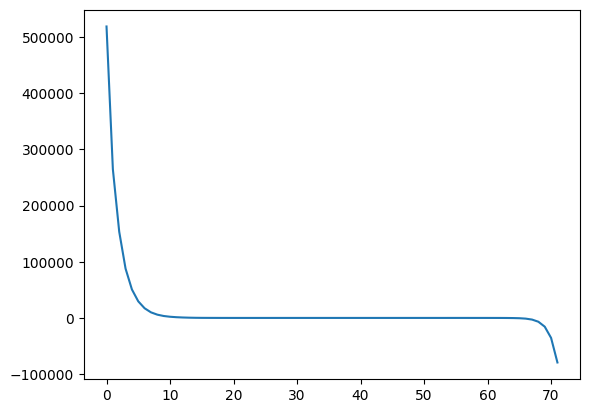

In [ ]:
proton_all[:, 0, 36:] *= -1
proton_all[:, 1, 54:] *= -1
proton_all[:, 3, 18:] *= -1
for tidx, tsrc in enumerate(range(0, 72, 18)):
    proton_all[:, tidx] = np.roll(proton_all[:, tidx], -tsrc, 1)
plt.plot(np.arange(72), proton_all.real.mean((0, 1)))

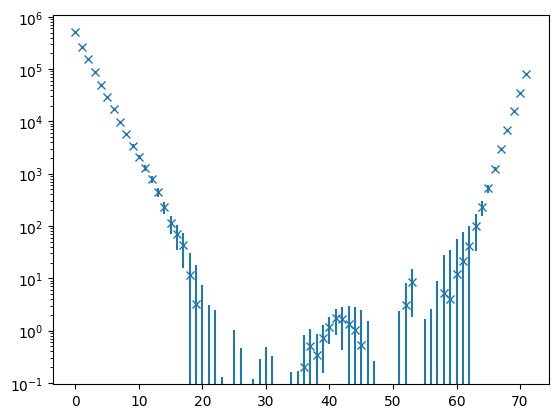

In [ ]:
proton_all_tsrc_mean = proton_all.mean(1)
proton_all_tsrc_mean[:, 36:] *= -1
plt.errorbar(np.arange(72), proton_all_tsrc_mean.real.mean(0), proton_all_tsrc_mean.real.std(0) / 38**0.5, fmt="x")
plt.yscale("log")